<a href="https://colab.research.google.com/github/restrepo/COVID-19/blob/master/covid_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 data

Use of [public Covid-19 in GitHub](https://github.com/CSSEGISandData/COVID-19) data from: 
[Center for Systems Science and Engineering (CSSE)](https://systems.jhu.edu/):

* Hongru Du, Lauren Gardner, and Ensheng Dong, An interactive web-based dashboard to track COVID-19 in real time, http://www.thelancet.com/infection Published:February 19, 2020, DOI:https://doi.org/10.1016/S1473-3099(20)30120-1

As an example of use of the data, we want to reproduce the results of:
* [Así evoluciona la curva del Coronavirus en España y en cada CCAA](https://elpais.com/sociedad/2020/03/13/actualidad/1584091954_865510.html)

<img src='https://github.com/restrepo/Covid-19/blob/master/img/elpais.png?raw=1' height="80" >

and to make similar plots for other countries


In [28]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['DataSource']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
import pandas as pd
import re
#See https://strftime.org/
import datetime
import time

In [0]:
def get_sum_series(cvn):
    cs=cvn.sum()
    cs['Province/State']='All'
    cs['Country/Region']=cvn['Country/Region'].unique()[0]
    cs['Lat']=round( cvn['Lat'].mean(),3 )
    cs['Long']=round( cvn['Long'].mean(),3 )
    return cs

def merge_country(cva):
    cvo=pd.DataFrame()

    multi_country=[]
    for c in cva['Country/Region']:
        if c not in multi_country:
            cvn=cva[cva['Country/Region']==c].reset_index(drop=True)
            if cvn.shape[0]>1:
                multi_country.append(c)
                cvo=cvo.append(get_sum_series(cvn),ignore_index=True)
            else:
                cvo=cvo.append(cvn,sort=False)

    cvo=cvo[cva.columns].reset_index(drop=True)

    #Special cases
    sc=cva[cva['Province/State']=='Hong Kong'].reset_index(drop=True)
    sc['Country/Region']='Hong Kong'
    if sc.shape[0]==1:
        cvo=cvo.append(sc,sort=False)
        cvo=cvo.reset_index(drop=True)    
    return cvo

## Load data

In [0]:
ALL_DATA=True
DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
DataDir='master/csse_covid_19_data/csse_covid_19_time_series/'
DataFile='time_series_19-covid-Confirmed.csv'
cva=pd.read_csv('{}{}{}'.format(DataSource,DataDir,DataFile))
cva=cva.reset_index(drop=True)
if ALL_DATA:
    DataDeaths='time_series_19-covid-Deaths.csv'
    time.sleep(1)
    cvd=pd.read_csv('{}{}{}'.format(DataSource,DataDir,DataDeaths))
    cvd=cvd.reset_index(drop=True)
    time.sleep(1)
    DataRecovered='time_series_19-covid-Recovered.csv'
    cvr=pd.read_csv('{}{}{}'.format(DataSource,DataDir,DataRecovered))
    cvr=cvr.reset_index(drop=True)

## Normalize data
Be sure to have only a row for country

In [32]:
cv=merge_country(cva)
print(cv.shape)
if ALL_DATA:
    cvd=merge_country(cvd)
    cvr=merge_country(cvr)

(172, 65)


In [33]:
cvd

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,4,4,5,6,6,6,6,6,6,6,6,10,10,15,16,19,22,22,27,29,29,29,33,35,40
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,3,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,NaN,Grenada,12.1165,-61.6790,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
168,NaN,Mozambique,-18.6657,35.5296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
169,NaN,Syria,34.8021,38.9968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
170,NaN,Timor-Leste,-8.8742,125.7275,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Make a list from infections rows

In [34]:
d=[ c for c in cv.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[1920]{2}',c)]

#https://www.tutorialspoint.com/How-to-sort-a-Python-date-string-list
#updeted date
cv['tolist']=cv[d].values.tolist()
dd=[ c for c in cvd.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[1920]{2}',c)]
cvd['tolist']=cvd[dd].values.tolist()
dr=[ c for c in cvr.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[1920]{2}',c)]
cvr['tolist']=cvr[dd].values.tolist()


d.sort(key=lambda date: datetime.datetime.strptime(date, "%m/%d/%y"))

cv[:1]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,tolist
0,NaN,Thailand,15.0,101.0,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,411,599,"[2, 3, 5, 7, 8, 8, 14, 14, 14, 19, 19, 19, 19,..."


In [35]:
dmax=d[-1]
dmax

'3/22/20'

## Reproduce "El País" plot
Set of minimal number of infections to catch up the exponential growth: `mininf=50`

Text(0, 0.5, 'infections')

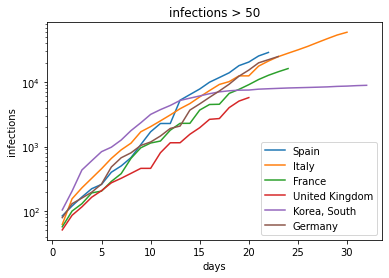

In [36]:
cntr=['Spain','Italy','France','United Kingdom','Korea, South','Germany']

mininf=50
for c in cntr:
    idxs=cv[ cv['Country/Region']== c ].index
    if len(idxs)==1:
        idx=idxs[0]
    else:
        print('Several Province/State')
        
    y=[l for l in cv.loc[idx,'tolist'] if l>mininf]
    ylen=len(y)
    x=range( 1,ylen+1 )
    #plt.semilogy(x,y,label='{}'.format(c))
    plt.plot(x,y,label='{}'.format(c))
    
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.title('infections > {}'.format(mininf))
plt.xlabel('days')
plt.ylabel('infections')
#plt.xlim(1,10)
#plt.ylim(1,200)
#plt.savefig('elpais_recover_2020_03_16.png')

### From [Donde estará el pico...](https://sistemaencrisis.es/2020/03/20/covid-19-donde-estara-el-pico-de-decesos-estableciendo-una-cota-inferior-en-base-a-la-curva-china/)

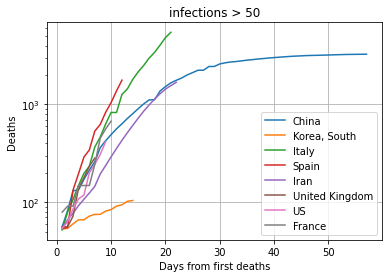

In [37]:
cntr=['China','Korea, South','Italy','Spain','Iran','United Kingdom','US','France']

deaths=50
for c in cntr:
    idxs=cvd[ cvd['Country/Region']== c ].index
    if len(idxs)==1:
        idx=idxs[0]
    else:
        print('Several Province/State')
        
    y=[l for l in cvd.loc[idx,'tolist'] if l>deaths]
    ylen=len(y)
    x=range( 1,ylen+1 )
    #plt.semilogy(x,y,label='{}'.format(c))
    plt.plot(x,y,label='{}'.format(c))
    
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.title('infections > {}'.format(mininf))
plt.xlabel('Days from first deaths')
plt.ylabel('Deaths')
plt.grid()
#plt.xlim(1,10)
#plt.ylim(1,200)
#plt.savefig('elpais_recover_2020_03_16.png')

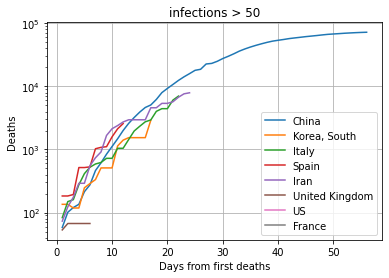

In [38]:
cntr=['China','Korea, South','Italy','Spain','Iran','United Kingdom','US','France']

deaths=50
for c in cntr:
    idxs=cvr[ cvr['Country/Region']== c ].index
    if len(idxs)==1:
        idx=idxs[0]
    else:
        print('Several Province/State')
        
    y=[l for l in cvr.loc[idx,'tolist'] if l>deaths]
    ylen=len(y)
    x=range( 1,ylen+1 )
    #plt.semilogy(x,y,label='{}'.format(c))
    plt.plot(x,y,label='{}'.format(c))
    
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.title('infections > {}'.format(mininf))
plt.xlabel('Days from first deaths')
plt.ylabel('Deaths')
plt.grid()
#plt.xlim(1,10)
#plt.ylim(1,200)
#plt.savefig('elpais_recover_2020_03_16.png')

## Make similar plots for all the countries

Country Lat
--------------------
Japan 36.0
Singapore 1.2833
Iraq 33.0
Bahrain 26.0275
Kuwait 29.5
Hong Kong 22.3
--------------------


(40, 30000)

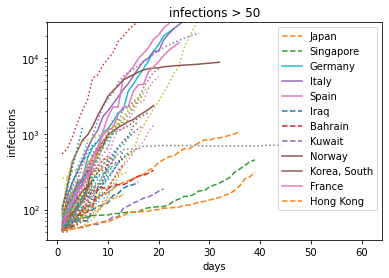

In [39]:
print('Country','Lat')
print('-'*20)
cntr=cv['Country/Region'].values
low_countries=[]
mininf=50
days_after=13
maxinf=300
for c in cntr:
    idxs=cv[ cv['Country/Region']== c ].index
    #Avoid multi_contry entries
    if len(idxs)==1:
        idx=idxs[0]
    else:
        pass
        #print('Several Province/State')
        
    y=[l for l in cv.loc[idx,'tolist'] if l>mininf]
    ylen=len(y)
    x=range( 1,ylen+1 )
    if len(x)>days_after and y[days_after]<maxinf:
        low_countries.append(c)
        print(c,cv.loc[idx,'Lat'])
    if c in ['Spain','Italy','France','Norway','Korea, South','Germany']:
        plt.plot(x,y,label='{}'.format(c))
    elif c in low_countries:
        plt.plot(x,y,'--',label='{}'.format(c))
    else:
        plt.plot(x,y,':')

print('-'*20)
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.title('infections > {}'.format(mininf))
plt.xlabel('days')
plt.ylabel('infections')
#plt.xlim(10,20)
plt.ylim(mininf-10,30000)

## Slow-exponential-growth countries

Country Lat
--------------------
Thailand 15.0
Japan 36.0
Singapore 1.2833
Malaysia 2.5
Australia -24.503
Taiwan* 23.7
Vietnam 16.0
Hong Kong 22.3
--------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


(7.045825766591295, 7000)

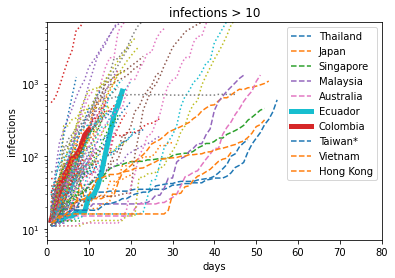

In [40]:
print('Country','Lat')
print('-'*20)
cntr=cv['Country/Region'].values
low_countries=[]
mininf=10
days_after=35
maxinf=400
for c in cntr:
    idxs=cv[ cv['Country/Region']== c ].index
    #Avoid multi_contry entries
    if len(idxs)==1:
        idx=idxs[0]
    else:
        pass
        #print('Several Province/State')
        
    y=[l for l in cv.loc[idx,'tolist'] if l>mininf]
    ylen=len(y)
    x=range( 1,ylen+1 )
    if len(x)>days_after and y[days_after]<maxinf:
        low_countries.append(c)
        print(c,cv.loc[idx,'Lat'])
    if c in ['Ecuador','Colombia']:
        plt.plot(x,y,label='{}'.format(c),lw=5)
    elif c in low_countries:
        plt.plot(x,y,'--',label='{}'.format(c))
    else:
        plt.plot(x,y,':')

print('-'*20)
plt.legend(loc='upper right')
plt.xscale('linear')
plt.yscale('log')
plt.title('infections > {}'.format(mininf))
plt.xlabel('days')
plt.ylabel('infections')
plt.xlim(0,80)
plt.ylim(mininf-10,7000)

To check the reason why some contries may no exhibit an strong exponential growth, see [References](./covid.ipynb#References) at the end


## Latin America

Text(0, 0.5, 'infections')

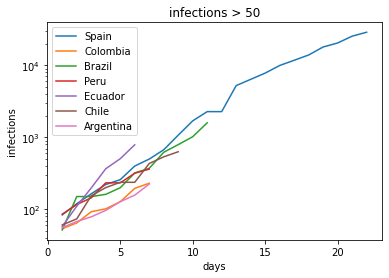

In [56]:
cntr=['Spain','Colombia','Brazil','Peru','Ecuador', 'Chile','Argentina']

mininf=50
for c in cntr:
    idxs=cv[ cv['Country/Region']== c ].index
    if len(idxs)==1:
        idx=idxs[0]
    else:
        print('Several Province/State')
        
    y=[l for l in cv.loc[idx,'tolist'] if l>mininf]
    ylen=len(y)
    x=range( 1,ylen+1 )
    #plt.semilogy(x,y,label='{}'.format(c))
    plt.plot(x,y,label='{}'.format(c))
    
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.title('infections > {}'.format(mininf))
plt.xlabel('days')
plt.ylabel('infections')
#plt.xlim(1,12)
#plt.ylim(1,200)
#plt.savefig('elpais_recover_2020_03_16.png')

## Fit to exponential model
See: Jupyter Notebook `covid19_analysis.ipynb`: [[local](./covid19.ipynb)] [[GitHub](https://github.com/restrepo/Covid-19/blob/master/covid.ipynb)] [[Colab](https://colab.research.google.com/github/restrepo/Covid-19/blob/master/covid.ipynb)] 

## Other models
* Fractal kinetics of COVID-19 pandemic, Anna L. Ziff, Robert M. Ziff
medRxiv 2020.02.16.20023820; doi: https://doi.org/10.1101/2020.02.16.20023820
    * (https://www.zdnet.com/article/graph-theory-suggests-covid-19-might-be-a-small-world-after-all/)
> Rather, the authors observed a period of initial exponential growth, followed by what's called a "power law," which is not the same thing.
* A mathematical model for the novel coronavirus epidemic in Wuhan, Chayu Yang, Jin Wang, Mathematical Biosciences and Engineering, 2020, 17(3): 2708-2724. doi: [10.3934/mbe.2020148](http://dx.doi.org/10.3934/mbe.2020148).
    * [SIR Model](https://es.wikipedia.org/wiki/Modelo_SIR)

* [Data minning](https://sistemaencrisis.es/2020/03/20/covid-19-donde-estara-el-pico-de-decesos-estableciendo-una-cota-inferior-en-base-a-la-curva-china/)

## References
About meteorological conditions for Covid-19

* Sajadi, Mohammad M. and Habibzadeh, Parham and Vintzileos, Augustin and Shokouhi, Shervin and Miralles-Wilhelm, Fernando and Amoroso, Anthony, Temperature and Latitude Analysis to Predict Potential Spread and Seasonality for COVID-19 (March 5, 2020). Available at SSRN: https://ssrn.com/abstract=3550308 or http://dx.doi.org/10.2139/ssrn.3550308
    * [El coronavirus en tierra caliente: ¿igual, peor o menos grave?](https://www.elespectador.com/coronavirus/el-coronavirus-en-tierra-caliente-igual-peor-o-menos-grave-articulo-909335)

* Wang, Jingyuan and Tang, Ke and Feng, Kai and Lv, Weifeng, High Temperature and High Humidity Reduce the Transmission of COVID-19 (March 9, 2020). Available at SSRN: https://ssrn.com/abstract=3551767 or http://dx.doi.org/10.2139/ssrn.3551767 
> $R = 3.968 - 0.0383\cdot \text{Temperature} - 0.0224\cdot \text{Relative Humidity}$
    * [Twitter thread](https://twitter.com/zuluagajorge/status/1239925580038049793)
* [Singapore contained Coronavirus. Could other countries learn from its approach?](https://www.weforum.org/agenda/2020/03/singapore-response-contained-coronavirus-covid19-outbreak/)
* [Will spring slow spread of coronavirus in northern hemisphere?](https://www.theguardian.com/world/2020/mar/11/will-spring-slow-spread-of-coronavirus-in-northern-hemisphere)
* [Coronavirus: Why You Must Act Now](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca)
* [Es muy probable que el SARS-COV-2 se atenúe y vuelva cada invierno, como la gripe](https://www.elespectador.com/coronavirus/es-muy-probable-que-el-sars-cov-2-se-atenue-y-vuelva-cada-invierno-como-la-gripe-articulo-909696)
> Las altas temperaturas son excelentes porque los coronavirus son muy sensibles al calor: cada día que pasan a 37 grados, pierden 10 veces su infectividad. Por tanto, en tres días calentitos se bajaría mil veces su capacidad de infección.
* Jin Bu, Dong-Dong Peng, Hui Xiao, Qian Yue, Yan Han, Yu Lin, Gang Hu, Jing Chen, Analysis of meteorological conditions and prediction of epidemic trend of 2019-nCoV infection in 2020, medRxiv 2020.02.13.20022715; doi: https://doi.org/10.1101/2020.02.13.20022715
> From a global perspective, cities with a mean temperature below 24 degree Celsius are all high-risk cities for 2019-nCoV transmission before June.

## Appendix

In [0]:
R=lambda T,H: 3.968 - 0.0383*T - 0.022*H

Global results in Fig. 4 (a) March (b) July in http://dx.doi.org/10.2139/ssrn.3551767

In [43]:
# Japan - July from paper
R(28,85)

1.0256

In [44]:
# Medellín - March from https://en.wikipedia.org/wiki/Medell%C3%ADn#Climate
R(23,65)

1.6571

In [45]:
# Bogotá - March from https://en.wikipedia.org/wiki/Bogot%C3%A1#Climate
R(15,75)

1.7435

## Model
See
https://www.youtube.com/watch?v=Kas0tIxDvrg&feature=youtu.be&t=249

$$N_d=(1+E p)^d N_0$$
where $d$ is the number of days, and $N_0$ is the intial number of infections

In [0]:
Ep=0.5
xlen=6
xx=list(range(1,xlen))
yy=[y[4]]+[int((1+Ep)**d*y[4]) for d in xx[:-1]]

In [47]:
xx

[1, 2, 3, 4, 5]

In [0]:
xini=xx[0]

In [49]:
y[4:]

[19, 31, 34, 45, 56, 68, 79, 97, 128, 158, 225]

In [50]:
y[xini:xini+xlen]

[12, 17, 19, 19, 31, 34]

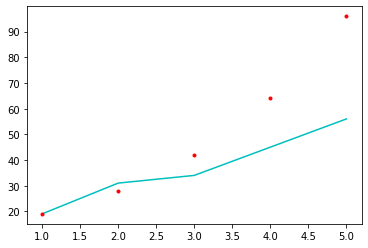

In [51]:
xini=4
plt.plot(xx,y[xini:xini+xlen-1],'c-',label=c)
plt.plot(xx,yy,'r.')

In [52]:
int((1+Ep)**4*y[4])

96

Prediction next day

In [53]:
day=5
int((1+Ep)**day*y[4])

144

In [54]:
cv[cv['Country/Region']=='Colombia'][[dmax]]

,3/22/20
73,231
